# Group Mahalanobis Project 1


## Introduction/Brief Description

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nam pulvinar sagittis erat, eget commodo lectus luctus in. Sed a erat eget felis convallis ultricies. Morbi pharetra quam at volutpat pharetra. Donec bibendum ex sed dignissim imperdiet. Proin fringilla purus tellus, vel posuere eros sagittis vitae. Cras commodo suscipit dui, quis commodo ex pharetra sed. Orci varius natoque penatibus et magnis dis parturient montes, nascetur ridiculus mus. Ut elit massa, dignissim et dui at, molestie hendrerit dui. Nunc non blandit tellus.


## Project Deliverables

### [#A] Data Imports

In [3]:
"""
If necessary, uncomment and install:
"""
#!pip install wbdata
#!pip install cufflinks
#!pip install iso3166

import iso3166 #iso3166.countries.get('country details')
import wbdata
import cufflinks as cf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cf.go_offline()

We are using data from **Source 40: "Population Estimates and Projections"**. We can also use **wbdata.get_topic()** and **wbdata.get_indicator()** to explore other datasets.

WBDATA API ref: https://wbdata.readthedocs.io/en/stable/wbdata_library.html

In [4]:
#wbdata.get_source() to get all sources
#wbdata.get_topic()
#wbdata.get_indicator()

source_id = 40 #Population Estimates and Projections
indicators = wbdata.get_indicator(source=source_id)

### [#A] Population DataFrames

A function that returns a pandas DataFrame
indexed by Region or Country and Year, with
columns giving counts of people in different
age-sex groups:

**pop_df (year, group, age_lower, age_upper, location)**

In [5]:
"""
population ranges available from dataset:
00-04, 05-09, 10-14, 15-19, 20-24, 25-29, 30-34, ..., 70-74, 75-79, above 80
"""

def pop_df(year='2021', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df_helper(year, age_lower, age_upper, location)
        
    if group == 'males':
        return df.drop(columns = ['Female'])
    elif group == 'females':
        return df.drop(columns = ['Male'])
    else:
        total_pop = df["Female"] + df["Male"]
        df["Total"] = total_pop
    return df

# Returns a list of input strings for population age ranges
def pop_df_helper(year, age_lower, age_upper, location):
    if location != 'world':
        country_alpha3 = iso3166.countries.get(location).alpha3
        country_name = iso3166.countries.get(location).apolitical_name
    else:
        country_alpha3 = 'WLD'
        country_name = 'World'
    inputs = list_of_age_inputs(age_lower, age_upper)

    #create indicator-dictionaries required for WBData API
    indicator_dict_m = {}
    indicator_dict_f = {}
    for i in inputs:
        key_m = "SP.POP.{}.{}".format(i, 'MA')
        key_f = "SP.POP.{}.{}".format(i, 'FE')
        value = "{}-{}".format(i[:2], i[2:])
        indicator_dict_m[key_m] = value
        indicator_dict_f[key_f] = value

    #source_id = 40, refer to wbdata.get_source()
    wbdf_m = wbdata.get_dataframe(indicator_dict_m, country=country_alpha3, source=source_id)
    wbdf_f = wbdata.get_dataframe(indicator_dict_f, country=country_alpha3, source=source_id)
    datas_m = wbdf_m.query("date=='{}'".format(year)).sum(axis=0).tolist()
    datas_f = wbdf_f.query("date=='{}'".format(year)).sum(axis=0).tolist()
    df = pd.DataFrame({
        'Country': country_name,
        'Year': year,
        'Age': list(indicator_dict_m.values()),
        'Female': datas_f,
        'Male': datas_m
    })
    return df

# Returns a list of input strings for population age ranges
def list_of_age_inputs(age_lower, age_upper):
    def round_down(n):
        return max(0, n - n % 5)

    def round_up(n):
        return n - n % 5 + 5

    results = []
    r_lower_bound, r_upper_bound = round_down(age_lower), round_up(age_upper)   
    while r_lower_bound < min(79, r_upper_bound):
        results.append("{:02d}{:02d}".format(r_lower_bound, r_lower_bound + 4))
        r_lower_bound += 5
    if age_upper >= 80:
        results.append('80UP')
    return results

The **pop_df** function takes in the year, target group, age lower/upper bounds and the country as arguments. The function returns a dataframe.

Variables:

In [6]:
year = 2015 #1960 to 2050 (projections)
group = 'all' #males/females/all
age_lower = 13 #rounds to nearest 5 (actual range: 10 to 65)
age_upper = 61
location = 'myanmar' #accepts country names/abbreviations, 'world'

Function call and output:

In [7]:
pop_df(year, group, age_lower, age_upper, location)

,Country,Year,Age,Female,Male,Total
0,Myanmar,2015,10-14,2588926.0,2604586.0,5193512.0
1,Myanmar,2015,15-19,2490373.0,2475952.0,4966325.0
2,Myanmar,2015,20-24,2328369.0,2279718.0,4608087.0
3,Myanmar,2015,25-29,2193006.0,2101669.0,4294675.0
4,Myanmar,2015,30-34,2076476.0,2001417.0,4077893.0
5,Myanmar,2015,35-39,2008285.0,1872498.0,3880783.0
6,Myanmar,2015,40-44,1882127.0,1701604.0,3583731.0
7,Myanmar,2015,45-49,1700927.0,1489300.0,3190227.0
8,Myanmar,2015,50-54,1455573.0,1225762.0,2681335.0
9,Myanmar,2015,55-59,1241131.0,999603.0,2240734.0


A dataframe is returned with the above format. The returned dataframe can be used to construct visualizations.

### [#A] Population Statistics

A python function named population
that will deliver information to
answer the queries of the following
form:

In [year] how many
[people/males/females] aged [low] to
[high] were living in [the
world/region/country]?

**pop_stats (year, group, age_lower, age_upper, location)**

In [8]:
def pop_stats(year='2021', group='all', age_lower=0, age_upper=100, location='world'):
    df = pop_df(year, group, age_lower, age_upper, location)
    inputs = list_of_age_inputs(age_lower, age_upper);
    total = df.sum()[3]
    t = total.astype(int)
    age_l = inputs[0][0:2]
    
    if group == 'people':
        g = 'people'
    else:
        g = group
        
    if age_upper >= 80:
        age_h = '80 or over'
    else:
        age_h = inputs[-1][2:4]
    
    if location == 'world':
        loc = 'the world'
    else:
        loc = iso3166.countries.get(location).apolitical_name
    
    if year > 2021:
        print("By estimation, in {}, there will be {} {} aged {} to aged {} living in {}.".format(year, t, g, age_l, age_h, loc))
    else:
        print("In {}, there are {} {} aged {} to aged {} living in {}.".format(year, t, g, age_l, age_h, loc))
        

Our **pop_stats** function takes in the year, target group, age lower/upper bounds and the country as arguments. The function returns a summary containing the information we need.

Variables:

In [9]:
year = 2021
group = 'males'
age_lower = 10
age_upper = 45
location = 'world'

Function call and output:

In [10]:
pop_stats(year, group, age_lower, age_upper, location)

In 2021, there are 2341749700 males aged 10 to aged 49 living in the world.


### [#B] Population Pyramids

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, and constructs a
“population pyramid” graph for
visualizing the data.

**draw_pop_pyramid (dataframe)**

In [11]:
def draw_pop_pyramid(dataframe):
    #get a dataframe by calling pop_df
    df = pop_df(year, group, age_lower, age_upper, location)
    #negate values under 'Male'
    df['Male'] = df['Male'].apply(lambda x: -x)
    #remove unnecessary columns
    df.drop(columns = ['Country', 'Year', 'Total'])

    AgeClass = df['Age'][::-1]
    bar_plot = sns.barplot(x='Female', y='Age', data=df, order=AgeClass)
    bar_plot = sns.barplot(x='Male', y='Age', data=df, order=AgeClass)
    bar_plot.set(xlabel="Population (millions)", ylabel="Age-Group", title = "Population Pyramid")

**draw_pop_pyramid** function call and output:

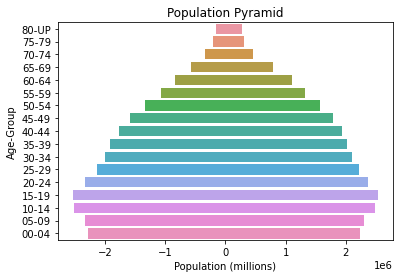

In [12]:
year = 2018
group = 'all'
age_lower = 0
age_upper = 80
location = 'myanmar'

df = pop_df(year, group, age_lower, age_upper, location)
draw_pop_pyramid(df) 

#### Functions we have so far:
**pop_df(year, group, age_lr, age_up, location)**: returns a dataframe for visualizations<br>
**pop_stats(year, group, age_lr, age_up, location)**: returns a print statement containing population information<br>
**draw_pop_pyramid(dataframe)**: accepts a dataframe created using pop_df(), and creates a population histogram

### [#C] Animated Population Pyramids

A python function that takes as
input a pandas DataFrame with
columns providing counts of people by
age-sex groups, with rows
corresponding to different years, and
constructs an animated “population
pyramid” graph for visualizing how the
population changes over time.

### [#C] Population Maps

A Jupyter notebook which queries a
population database and provides
visualizations in the form of maps.
An example of a library that may be
useful is geopandas.

### [#C] Other Visualization Tools

If you think of other ways to organize
or visualize population and how it
changes over time, this is for you!

### [#C] Agricultural Supply

Relate changes in agricultural food supply
to changes in population.

What would Malthus think?

## Skills

[#A] Jupyter Notebooks
Basic manipulations of Jupyter notebooks
on https://datahub.berkeley.edu

[#A] Use of Indicators API from python
Use the Indicators API to query the
on-line World Development Indicators
database.

[#A] Build pandas.DataFrame
Collect data on population into a
pandas DataFrame.

[#B] Read on-line spreadsheets using python
[#B] Construct plots in python
Using matplotlib, plotly, or similar.

[#C] Construct world maps
Consider using plotly, geopandas, or similar.

## Further/Others